## 어텐션 Attention

### 1. 어텐션의 구조
- seq2seq를 한층 더 강력하게 하는 어텐션 메커니즘 덕분에 seq2seq는 필요한 정보에만 주목할 수 있게 됨

#### 1.1 seq2seq의 문제점
- seq2seq에서는 Encoder가 시계열 데이터를 인코딩하고 인코딩 된 정보를 Decoder로 전달
- 이때 Encoder의 출력은 고정 길이의 벡터. 고정길이는 항상 같은 길이의 벡터를 밀어 넣는 큰 문제가 잠재
- 필요한 정보가 벡터에 다 담기지 못하게 된다. Encoder와 Decoder 개선

#### 1.2 Encoder 개선
- LSTM 계층의 마지막 은닉 상태만을 Decoder에 전달
- Encoder 출력의 길이는 입력 문장의 길이에 따라 바꿔주는 것이 Encoder의 개선 포인트. 구체적으로 LSTM 계층의 은닉 상태 벡터를 모두 이용 하는 것이다
- 은닉 상태 벡터를 모두 이용하면 입력된 단어와 같은 수의 벡터를 얻고 Encoder는 하나의 고정 길이 벡터라는 제약으로부터 해방 된다
- 많은 딥러닝 프레임워크에서는 RNN 계층(혹은 LSTM, GRU 계층 등)을 초기화할 때, 모든 시각의 은닉 상태 벡터 반환과 마지막 은닉 상태 벡터만 반환 중 선택 가능
- Encoder의 은닉 상태를 모든 시각만큼 꺼냄으로써 입력 문장의 길이에 비례한 정보를 인코딩할 수 있게 됨

#### 1.3 Decoder 개선 ①
- Encoder는 각 단어에 대응하는 LSTM 계층의 은닉 상태 벡터를 hs로 모아 출력하고 hs가 Decoder에 전달되어 시계열 변환이 이루어 진다
- 입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가 라는 대응관계를 seq2seq에 학습
- 단어의 대응관계를 나타내는 정보를 얼라인먼트(alignment)라 하는데 지금까지 주로 사람의 수작업으로 만듦
- 도착어 단어와 대응 관계에 있는 출발어 단어의 정보를 골라내는 것. 그리고 그 정보를 이용하여 번역 수행
- 필요한 정보에만 주목하하여 그 정보로부터 시계열 반환을 수행하는 것이 목표
- Encoder로 부터 받은 hs, 시각별 LSTM계층의 은닉상태 2가지 입력을 받아 어떤 계산을 수행(얼라인먼트 추출)
- 대응벡터를 선택(미분가능하게 모든 벡터를 선택하여 가중치 계산). 단어의 중요도 가중치 a와 각 단어의 벡터 hs로부터 가중합을 구하여 맥락 벡터 c를 구한다

In [10]:
# 가중합 구현
# 시계열 길이 T=5, 은닉 상태 벡터 원소수 H=4로 가중합
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

# 브로드캐스트 이용도 가능하나 눈에 보이지 않으므로 형상화
ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [11]:
# 미니배치 처리용 가중합 구현
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1) # 브로드캐스트 사용하는 경우

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [12]:
# Weight Sum 계층
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)    # repeat의 역전파

        return dhs, da

#### 1.4 Decoder 개선 ②

- 가중치 a를 구하는 방법 살펴보기
- 지금의 목표는 Decoder의 LSTM 계층의 은닉 상태 벡터 h가 hs의 각 단어 벡터와 얼마나 비슷한가를 내적을 이용해 수치로 나타내는 것. 두 벡터의 유사도를 표현하는 척도
- h와 hs의 각 단어 벡터와의 유사도 결과 s. softmax를 통한 정규화하여 각 단어의 가중치 a 산출

In [1]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch08')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H)   # 브로드캐스트 사용하는 경우

t = hs * hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


In [3]:
# AttentionWeight 클래스 구현
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch08')
from common.np import * #import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hr, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

#### 1.5 Decoder 개선 ③
- Attention Weight 계층과 Weight Sum 계층을 구현. 이 두계층을 하나로 결합하여 Attention 계층
- Attention Weight 계층은 Encoder가 출력하는 각 단어의 벡터 hs에 주목하여 해당 단어의 가중치 a를 구한다
- Weight Sum 계층이 a와 hs의 가중합을 구하고, 그 결과를 맥락 벡터 c로
- Attention 계층을 LSTM 계층과 Affine 계층 사이에 삽입. Attention 계층에는 Encoder의 출력인 hs가 입력
- 또, 여기에 LSTM 계층의 은닉 상태 벡터를 Affine 계층에 입력
- 마지막으로 시계열 방향으로 펼쳐진 다수의 Attention 계층을 Time Attention 계층으로 모아 구현

In [4]:
# Attention 계층 구현
class Attention:
    def __init__(self):
        self.params, self.grads =[], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [5]:
# Time Attention 계층 구현
import outcome


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh

        return dhs_enc, dhs_dec


### 어텐션을 갖춘 seq2seq 구현

#### 2.1 Encoder 구현
- LSTM 계층의 마지막 은닉 상태 벡터만 반화했던 것을 모든 은닉 상태 반환으로 구현

In [6]:
# Encoder 상속하여 구현
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch08')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

#### 2.2 Decoder 구현
- forward, backward 메서드에 새로운 단어열(혹은 문자열) 생성 generate 메서드 추가
- forward() 메서드에서 Time Attention 계층의 출력과 LSTM 계층의 출력을 연결 (np.concatenate)

In [7]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()  # Attention 레이어 
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)  # context vector
        out = np.concatenate((c, dec_hs), axis=2)  # context_vector & lstm h_t
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

#### 2.3 seq2seq 구현
- Seq2seq 클래스 상속, AttentionEncoder, AttentionDecoder 클래스 사용 AttentionSeq2seq 구현

In [8]:
from ch07.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSofmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

### 3. 어텐션 평가

#### 3.1 날짜 형식 변환 문제
- 영어권에서 사용되는 다양한 날짜 형식을 표준 형식으로 변환하는 것이 목표
- ex) september 27, 1994 → 1994-09-27

#### 3.2 어텐션을 갖춘 seq2seq의 학습

In [12]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch08')
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07')
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 20
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3%%')

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 7[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 15[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 23[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 31[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 40[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 50[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 58[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 66[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 74[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 82[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 89[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 97[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 105[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 113[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 121[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 128[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 137[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22, 2

c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50

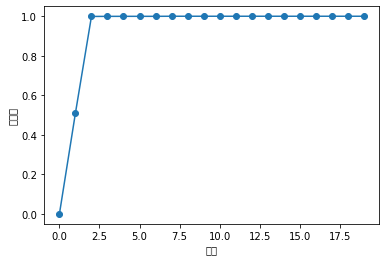

In [14]:
# 그래프 그리기
import matplotlib.pyplot as plt

x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

#### 3.3 어텐션 시각화
- 어텐션이 시계열 변환을 수행할 때, 어느 원소에 주의를 기울이는지를 살펴보려는 시도

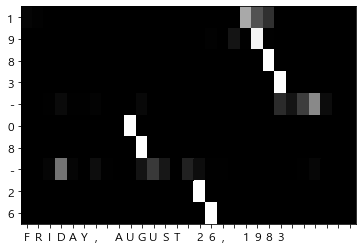

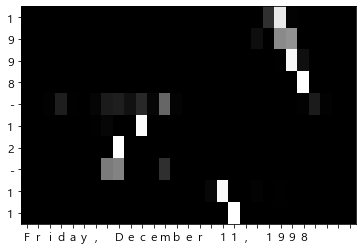

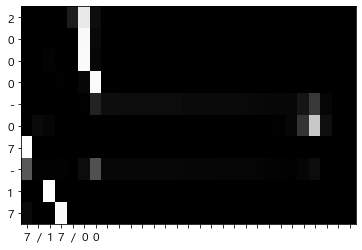

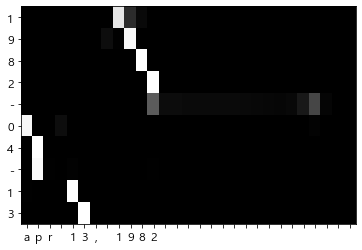

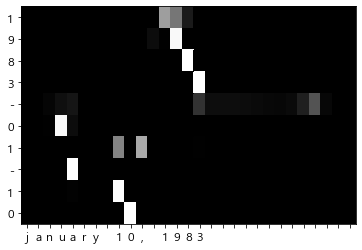

In [22]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch08')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)

from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

### 4. 어텐션에 관한 남은 이야기
- 어텐션에 관련하여 다루지 못한 주제 몇 가지 소개

#### 4.1 양방향 RNN
- seq2seq의 Encoder에 초점
- LSTM의 각 시각의 은닉상태 벡터는 hs로 모아진다
- 여기서 주목할 것은 글을 왼쪽에서 오른쪽으로 읽는다는 점이다. 따라서 '나', '는', '고양이', '로소', '이다' 예시에서 '고양이'에 대응하는 벡터에 '나', '는', '고양이' 까지 총 세 단어의 정보가 인코딩된다
- 전체적인 균형을 생각해 단어의 주변 정보를 균형있게 담고 싶을 것이다. 그래서 LSTM을 양방향으로 처리하는 방법이 양방향 LSTM(양방향RNN) 기술이다
- 기존 LSTM 계층에 역방향 처리 LSTM 계층을 추가. 각 시각에서 두 LSTM 계층의 은닉 상태를 연결시킨 벡터를 최종 은닉 상태로 처리(연결 외에 합이나 평균 등의 방법도 생각 할 수 있다)
- 2개의 LSTM 계층을 사용하여 각각의 계층에 주는 단어의 순서를 조정(왼쪽에서 오른쪽 + 오른쪽에서 왼쪽)

#### 4.2 Attention 계층 사용 방법
- 앞에서 Attention 계층을 LSTM 계층과 Affine 계층 사이에 삽입
- Attention 계층의 출력(맥락 벡터)이 다음 시각의 LSTM 계층에 입력되도록 연결하면 LSTM 계층이 맥락 벡터의 정보를 이용할 수 있다
- Attention 계층의 위치를 달리하는 게 최종 정확도에 주는 영향은 실제 데이터로 검증해봐야 한다

#### 4.3 seq2seq 심층화와 skip 연결
- 기계 번역 등 현실에서의 애플리케이션들은 풀어야 할 문제가 훨씬 북잡하고 더 높은 표현력이 요구된다
- 먼저 생각해야 할 것은 RNN계층(LSTM 계층)의 층을 깊게 쌓는 방법이다
- 일반적으로 Encoder와 Decoder에서는 같은 층수의 LSTM 계층을 이용한다
- 층을 깊게 할 때 사용되는 중요한 기법 중 skip connection 이 있다(잔차 연결 residual connection 또는 숏컷 short-cut 이라고도 한다). 계층을 넘어 선을 연결하는 단순한 기법이다
- skip 연결은 계층을 건너뛰는 연결로 이때 skip연결의 접속부에서는 2개의 출력이 더해진다. 이 덧셈이 핵심으로 덧셈은 역전파 시 기울기를 드래도 흘려보내므로, skip 연결의 기울기가 아무런 영향을 받지 않고 모든 계층으로 흐르기 떄문에 층이 깊어져도 기울기 소실(폭팔)되지 않는다

### 5. 어텐션 응용

#### 5.1 구글 신경망 기계 번역 (GNMT, Google Nueral Machine Translation)
- 기계 번역의 흐름 : 규칙 기반 → 용례 기반 → 통계 기반 → 신경망 기계 번역(Neural Machgine Translation)
- 신경망 기계 번역은 기존 통계 기반 번역과 대비되는 형태로 사용, 최근에는 seq2seq 사용한 기계 번역의 총칭
- GNMT도 어텐션을 갖춘 seq2seq와 마찬가지로 Encoder와 Decoder, Attention으로 구성
- 번역의 정확도를 높이기 위해 LSTM 계층의 다층화, 양방향 LSTM, skip 연경 등 개선 추가
- 학습 시간 단축하기 위해 다수의 GPU로 분산 학습을 수행
- 이상의 아키텍처적인 연구 외에도, 낮은 빈도의 단어 처리나 추론 고속화를 위한 양자화 등 다양한 연구

#### 5.2 트랜스포머 Transformer
- RNN은 이전 시각에 계산한 결과를 이용하여 순서대로 계싼. 따라서 시간 방향으로 병렬 계산하기란 불가능
- 이 점은 딥러닝 학습이 GPU를 사용한 병렬 계싼 환경에서 이뤄진다는 점을 생각하면 큰 병목 문제이다
- RNN을 없애거나 병렬 계산할 수 있는 연구가 활발 - Attention is all you need 논문에서 제안한 트랜스포머
- 트랜스포머는 어텐션으로 구성되는데, 그중 셀프어텐션 Self-Attention 기술을 이용하는게 핵심
- 하나의 시계열 데이터 내에서 각 원소가 다른 원소들과 어떻게 관련되는지 살펴보자는 취지의 Self-Attention
- Time Attention 계층에는 서로 다른 두 시계열 데이터가 입력되는 반면, Self-Attention은 두 입련이 모두 하나의 시계열 데이터로 부터 나온다. 이렇게 하면 하나의 시계열 데이터 내에서의 원소간 대응 관계가 구해진다
- 트랜스포머에서는 RNN 대신 Attention을 사용. 위의 그림을 보면 Encoder와 Decoder 모두에서 셀프어텐션을 사용한다. 또한 Feed Forward 계층은 피드포워드 신경망을 정확하게는 은닉층이 1개이고 활성화 함수로 ReLU를 이용한 완전 연결계층 신경망을 이용한다
- Nx는 해당 계층이 N겹 쌓였다는 뜻
- 트랜스포머를 이용하면 계산량을 줄이고 GPU를 이용한 병렬 계산의 혜택도 더 많이 누릴수 있고, 그 결과 GNMT보다 학습 시간을 큰 폭으로 줄이고 번역 품질도 상당 폭 끌어올릴 수 있었다


![](2022-07-16-08-30-12.png)

#### 5.3 뉴럴 튜링 머신 (Neural Turing Machine, NMT)
- 어텐션을 갖춘 seq2seq에서는 Encoder가 입력 문장을 인코딩한다. 그리고 인코딩된 정보를 어텐션을 통해 Decoder가 이용한다. 즉, Encoder가 필요한 정보를 메모리에 쓰고, Decoder는 그 메모리로부터 필요한 정보를 읽어 들인다
- 컴퓨터의 메모리 조작을 신경망에서도 재현. RNN의 외부에 정보 저장용 메모리 기능을 배치하고, 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법이다. 그중 유명한 연구가 뉴럴 튜링 머신이다
- NTM은 외부 메모리를 읽고 쓰면서 시계열 데이터를 처리. 이러한 메모리 조작을 미분가능한 계산으로 구축
- LSTM 계층이 컨트롤러가 되어 NTM의 주된 처리를 수행. 각 시각에서 LSTM 계층의 은닉 상태를 Write Head 계층이 받아서 필요한 정보를 메모리에 쓴다음 Read Head 계층이 메모리로부터 중요한 정보를 읽어 들여 다음 시각의 LSTM 계층으로 전달
- NTM은 컴퓨터의 메모리 조작을 모방하기 위해서 2개의 어텐션을 이용
- 콘텐츠 기반 어텐션 : 지금까지 본 어텐션과 같고, 입력으로 주어진 어느 벡트와 비슷한 벡터를 메모리로부터 찾아내는 용도로 이용
- 위치 기반 어텐션 : 이전 시각에서 주목한 메모리의 위치(=메모리의 각 위치에 대한 가중치)를 기준으로 그 전후로 이동(시프트)하는 용도로 사용
- 외부 메모리를 자유롭게 이용하게 됨으로써 NTM은 seq2seq 만으로 풀리지 않던 긴 시계열을 기억하는 문제와 정렬 등의 문제를 해결
- 외부 메모리를 사용함으로써 알고리즘을 학습하는 능력을 얻는다

### 6. 정리
- 번역이나 음성 인식 등, 한 시계열 데이터를 다른 시계열 데이터로 변환하는 작업에서는 시계열 데이터 사이의 대응관계가 존재하는 경우가 많다
- 어텐션은 두 시계열 데이터 사이의 대응 관계를 데이터로부터 학습한다
- 어텐션에는 벡터의 내적을 사용해 벡터 사이의 유사도를 구하고, 그 유사도를 이용한 가중합 벡터가 어텐션의 출력이 된다
- 어텐션에서 사용하는 연산은 미분 가능하기 때문에 오차역전파법으로 학습할 수 있다
- 어텐션이 산출하는 가중치를 시각화하면 입출력의 대응관계를 볼 수 있다
- 외부 메모리를 활용한 신경망 확장 연구 예에서는 메모리를 읽고 쓰는데 어텐션을 사용한다